# Привет. Мой профиль на Кагл https://www.kaggle.com/tarasovandrey

### Итоговый Score: 0.98512

### Team name: Andrey Tarasov 359896353(Stpk)

# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Проверка GPU на ПК

In [1]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [2]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
!nvidia-smi

Wed Nov 15 22:22:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 ...  WDDM  | 00000000:07:00.0  On |                  N/A |
| 25%   52C    P8               7W / 100W |   1397MiB /  4096MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import PIL
print(PIL.__version__)

8.4.0


In [5]:
torch.cuda.empty_cache()

## Импорт библиотек

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import random
import seaborn as sn

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import os

from collections import Counter
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm, trange
from tqdm import tqdm, tqdm_notebook

import pickle
import copy

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import time
%matplotlib inline

In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

## Функции в коде

In [8]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])            
     ])
        
    
        x = self.load_sample(self.files[index])
        
        x = self._prepare_sample(x)        
        x = np.array(x / 255, dtype='float32')
        
        x = transform(x) #раб
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

## Чтение данных

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс

In [10]:
from pathlib import Path
import zipfile

In [11]:
# # Указываете путь к папке с архивом на вашем локальном компьютере
# zip_path = Path('D:/Код_НИИАС/DLS/data/journey-springfield.zip')

# # Указываете путь, куда вы хотите извлечь содержимое архива
# extract_path = Path('D:/Код_НИИАС/DLS/data/journey-springfield')

# # Распаковываем архив
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# # Печатаем содержимое директории train
# print(list(extract_path.glob('*')))

In [12]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('D:/Код_НИИАС/DLS/data/journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('D:/Код_НИИАС/DLS/data/journey-springfield/testset/testset/')

train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))#путь до каждой картинки в формате: WindowsPath('journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg')
train_labels = [path.parent.name for path in train_files]#класс картинки в формате 'abraham_grampa_simpson'
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(len(train_val_files))

20933


In [14]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

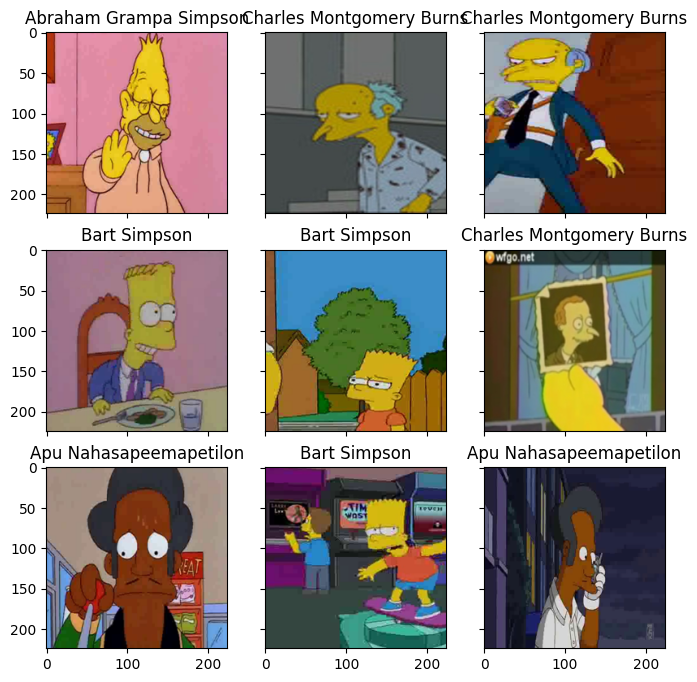

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Нейросетка

In [17]:
def fit_epoch(model, train_loader, criterion, sheduler, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    sheduler.step()
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=3e-4)
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, exp_lr_scheduler, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [21]:
n_classes = len(np.unique(train_val_labels))
#simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
#print(simple_cnn)

we will classify :42


In [22]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [23]:
model_efic = models.efficientnet_b0(pretrained=True)
print(model_efic.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [24]:
model_efic = models.efficientnet_b0(pretrained=True)
for param in model_efic.features[:-5].parameters():
    param.requires_grad = False
num_feature = model_efic.classifier[1].in_features
print(num_feature)
model_efic.classifier[1] = nn.Linear(num_feature, 42)
print(model_efic.classifier)

1280
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=42, bias=True)
)


## Обучение нейронки

In [25]:
import torch
torch.cuda.is_available()

True

In [26]:
history = train(train_dataset, val_dataset, model=model_efic.to('cuda'), epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.8852563987447089


epoch:  20%|██        | 1/5 [02:50<11:20, 170.11s/it]


Epoch 001 train_loss: 0.8853     val_loss 0.2189 train_acc 0.7972 val_acc 0.9484
loss 0.1905542171134699


epoch:  40%|████      | 2/5 [05:35<08:21, 167.14s/it]


Epoch 002 train_loss: 0.1906     val_loss 0.1751 train_acc 0.9507 val_acc 0.9564
loss 0.07558688795149181


epoch:  60%|██████    | 3/5 [08:21<05:33, 166.78s/it]


Epoch 003 train_loss: 0.0756     val_loss 0.1594 train_acc 0.9799 val_acc 0.9631
loss 0.04341583764502075


epoch:  80%|████████  | 4/5 [11:05<02:45, 165.77s/it]


Epoch 004 train_loss: 0.0434     val_loss 0.1939 train_acc 0.9879 val_acc 0.9505
loss 0.03684478771472799


epoch: 100%|██████████| 5/5 [13:51<00:00, 166.24s/it]


Epoch 005 train_loss: 0.0368     val_loss 0.1910 train_acc 0.9890 val_acc 0.9570


## Кривые обучения

In [27]:
loss, acc, val_loss, val_acc = zip(*history)

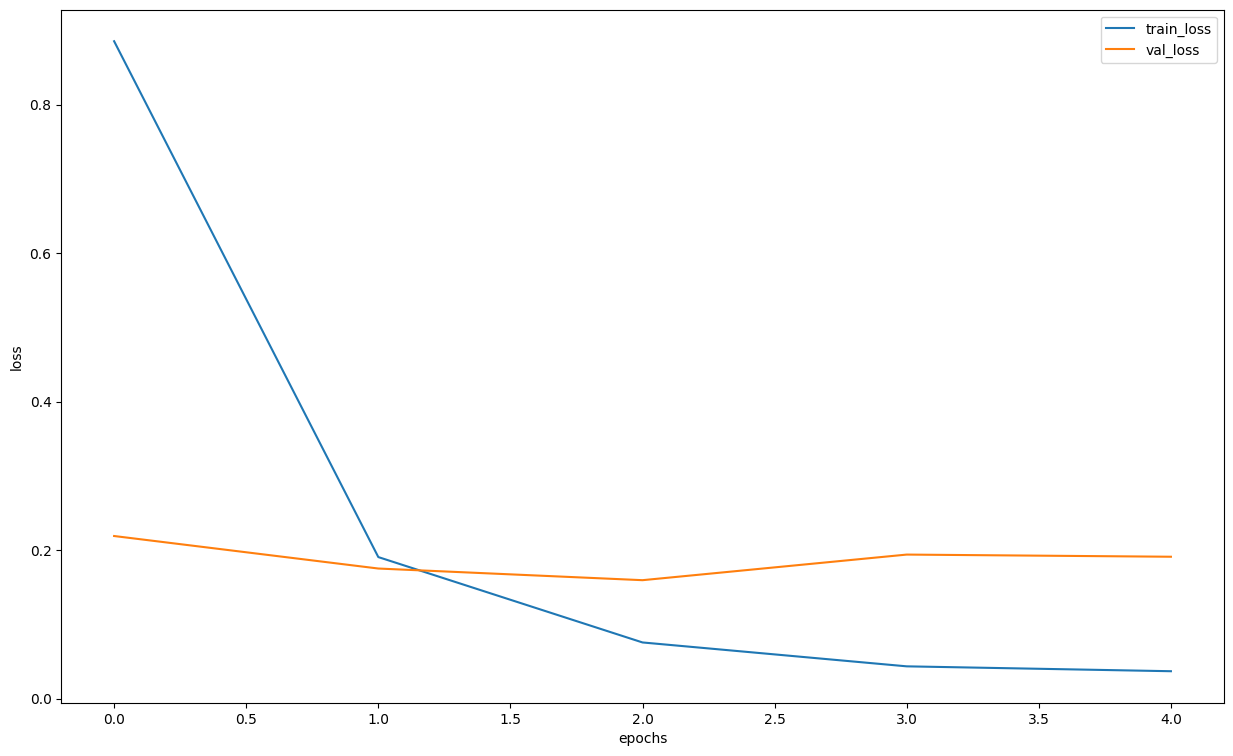

In [28]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [29]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [30]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_efic, ex_img.unsqueeze(0))

In [31]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_efic, imgs)

In [32]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [33]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

preds_class = label_encoder.transform(preds_class)

## Целевая метрика на валидационной выборке

In [34]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='micro')

0.9500000000000001

## Визуализация ответов нейросети

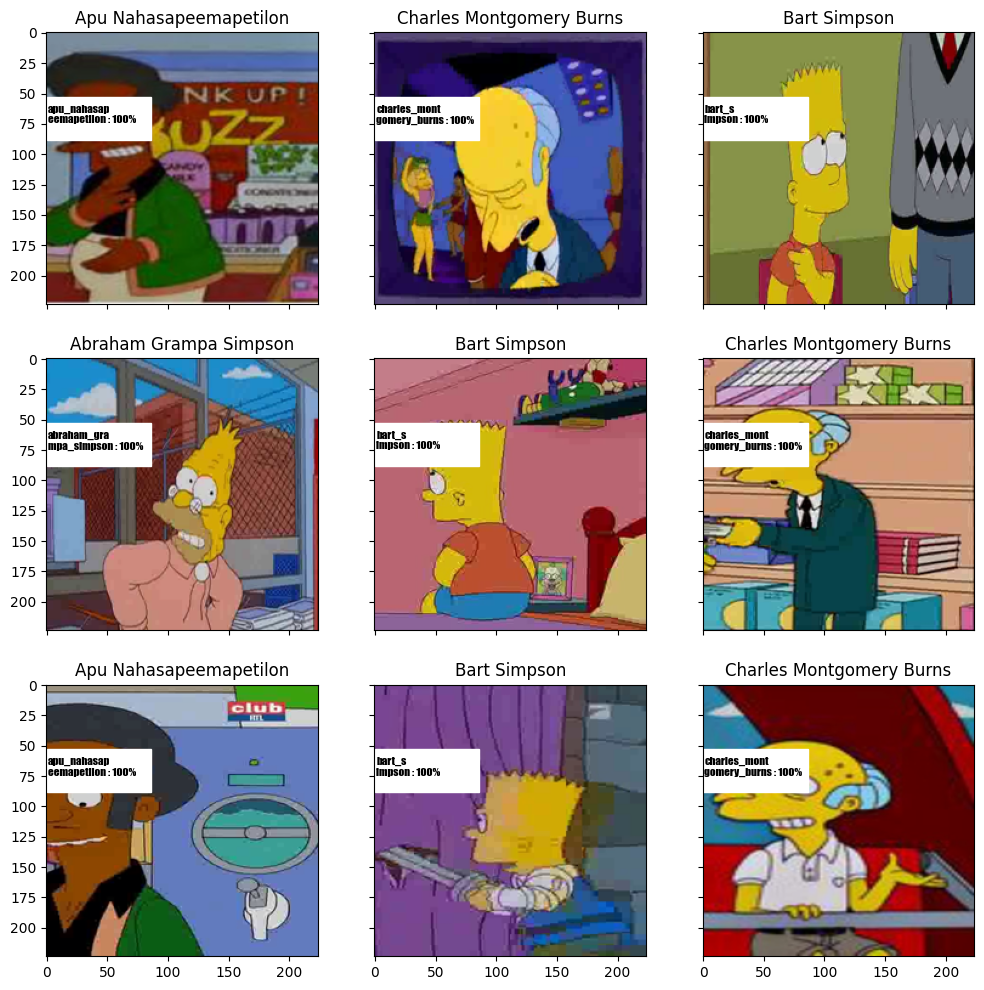

In [35]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_efic, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

## Submit на Kaggle

In [36]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_efic, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [37]:
my_submit = pd.DataFrame()
my_submit['Id'] = test_filenames
my_submit['Expected'] = preds
my_submit.to_csv('D:\\Код_НИИАС\\DLS\\save_data\\submission.csv', index=False)

In [38]:
import torch
torch.cuda.empty_cache()

# Score: 0.98512 на Кагл

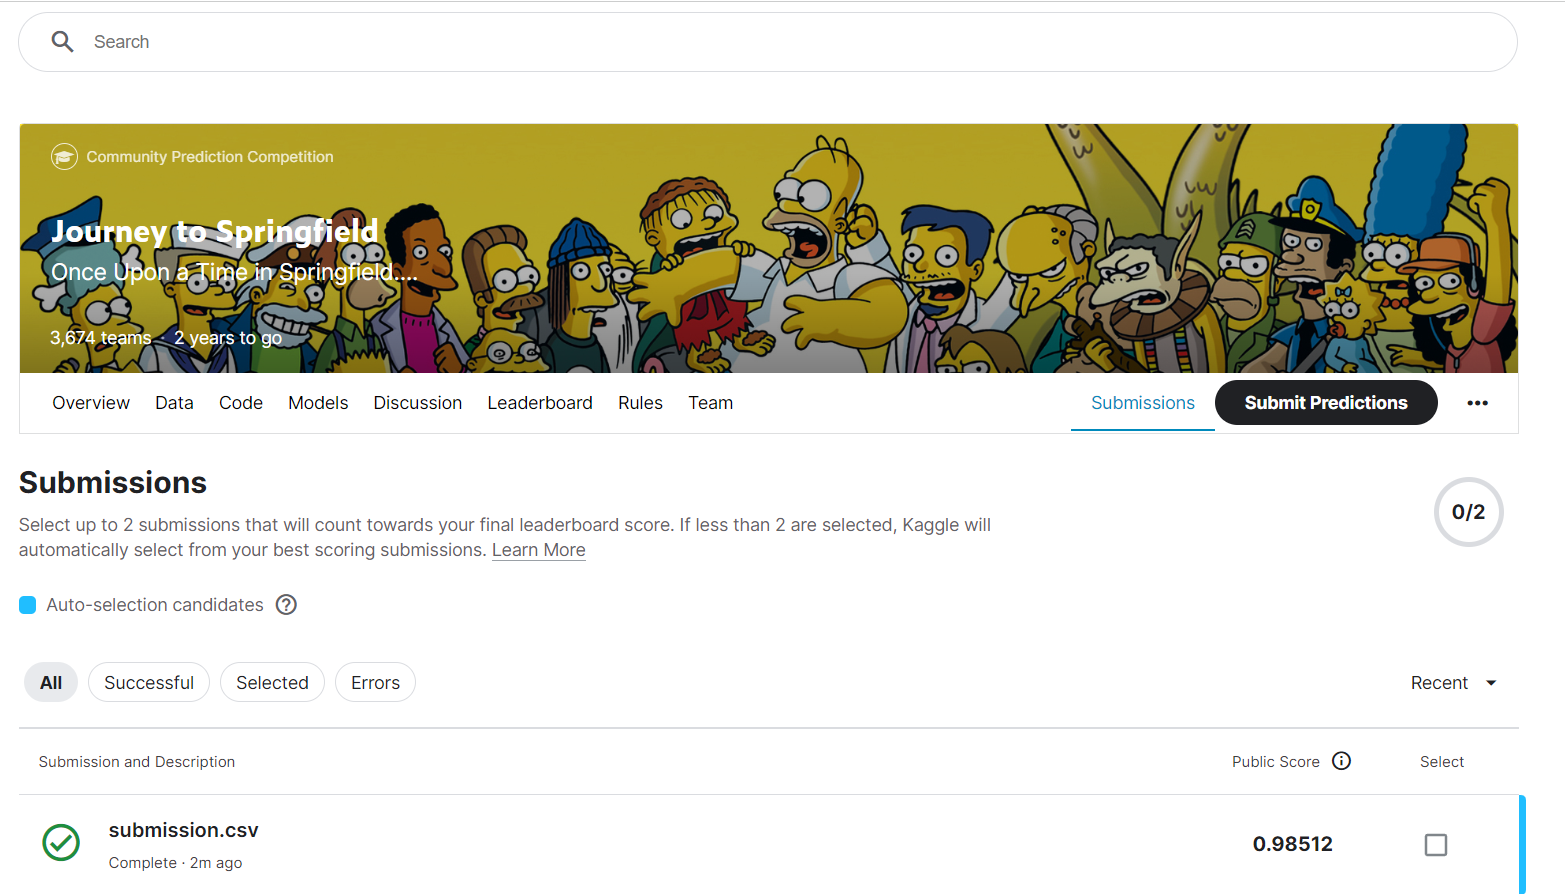